In [1]:
import warnings
warnings.filterwarnings('ignore')
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import lightgbm as lgb
import xgboost as xgb
from sklearn import svm
from sklearn.neural_network import MLPRegressor

import sklearn.metrics as mtr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_data=pd.read_csv('../data/ParameterListAll_20180702.csv',index_col=0)
columns=raw_data.columns

In [3]:
location_li=['IC_Pcom','IC_choro','MC_bifur','AC_Acom','A1_A2','AC_distal','BA_top','PCA','PICA']
raw_data['location']=np.zeros(len(raw_data))
for location in location_li:
    loc_id=raw_data[raw_data[location]==1].index
    raw_data['location'][loc_id]=location

In [4]:
raw_data['LastConsulation']=pd.to_datetime(raw_data['LastConsulation'])

raw_data['month']=raw_data['LastConsulation'].dt.month.astype('int')
idx_3=raw_data[raw_data['month']<=3].index
idx_6=raw_data[(raw_data['month']>3)&(raw_data['month']<=6)].index
idx_9=raw_data[(raw_data['month']>6)&(raw_data['month']<=9)].index
idx_12=raw_data[raw_data['month']>9].index
raw_data['month'][idx_3]='1-3'
raw_data['month'][idx_6]='4-6'
raw_data['month'][idx_9]='7-9'
raw_data['month'][idx_12]='10-12'

raw_data['day']=raw_data['LastConsulation'].dt.day.astype('int')
idx_10=raw_data[raw_data['day']<=10].index
idx_20=raw_data[(raw_data['day']>10)&(raw_data['day']<=20)].index
idx_30=raw_data[raw_data['day']>20].index
raw_data['day'][idx_10]='1-10'
raw_data['day'][idx_20]='11-20'
raw_data['day'][idx_30]='21-31'

In [5]:
category_col=['location','SideorBifur','Sex', 'RightLeft', 'MultiSingle', 'HT', 'HL', 'DM', 'Alchol',
              'PolycysticKindney', 'CerebralHemorrhage', 'CerebralInfant', 'SAH',
              'none', 'Smoke', 'family_SAH', 'family_An', 'family_PolycysticKindney','bleb','month','day']
raw_data[category_col]=raw_data[category_col].astype('category')

In [6]:
drop_li=['FirstDiagnosis', 'InitialConsultation', 'LastConsulation',
         'DateofRupture', 'Birthday', 'AgeatIniCon','Days','IC_Pcom',
         'IC_choro', 'MC_bifur', 'AC_Acom', 'A1_A2', 'AC_distal',
         'BA_top', 'PCA', 'PICA']
raw_data=raw_data.drop(drop_li,axis=1)

In [7]:
raw_data['PLcver2R']=(raw_data['TMAXPLcver2']/raw_data['TMINPLcver2']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['PLcOldver2R']=(raw_data['TMAXPLcOldver2']/raw_data['TMINPLcOldver2']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['ELR']=(raw_data['TMAXEL']/raw_data['TMINEL']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['ELVR']=(raw_data['TMAXELV']/raw_data['TMINELV']).replace([np.inf, -np.inf], np.nan).fillna(0)

raw_data['SCIR']=(raw_data['TMAXSCI']/raw_data['TMINSCI']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['LSIR']=(raw_data['TMAXLSI']/raw_data['TMINLSI']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['LSAR']=(raw_data['TMAXLSA']/raw_data['TMINLSA']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['ICIR']=(raw_data['TMAXICI']/raw_data['TMINICI']).replace([np.inf, -np.inf], np.nan).fillna(0)

In [8]:
features=['velocities','shear_force','pressure','wss']
statistics=['max','var']
feature_statistics=[f+'_'+m for m in statistics for f in features]
width_length=3
for i in range(len(feature_statistics)):
    data=pd.read_csv('../../VTK/output/'+feature_statistics[i]+'.csv',index_col=0)
    data['ID']=([x.split('/')[0] for x in list(data.index)])
    data=data.set_index('ID')
    data=data.drop('Unnamed: 19',axis=1)
    columns=[round(0.05*x,3) for x in range(18)]
    data.columns=columns
    
    for width in range(width_length):
        width+=1
        
        changed_data=data.pct_change(width,axis=1)
        changed_data=changed_data.drop([round(0.0+0.05*x,3) for x in range(width)],axis=1)
        columns=[feature_statistics[i]+'_'+str(round(0.05*x,3))+'_'+str(round(0.05*(x+width),3)) for x in range(18-width)]
        changed_data.columns=columns

        raw_data=raw_data.join(changed_data.replace([np.inf, -np.inf], np.nan).fillna(0))

In [9]:
def make_normal_data(raw_data):
    x=raw_data
    y=pd.DataFrame(x['Rupture'],columns=['Rupture'])
    x=x.drop('Rupture',axis=1)
    return x,y

In [10]:
def get_dummy(x,dummy_col):
    x_dummy=pd.get_dummies(x[dummy_col])
    x=pd.concat([x,x_dummy],axis=1)
    x=x.drop(dummy_col,axis=1)
    return x

In [11]:
x,y=make_normal_data(raw_data)
x_dummy=get_dummy(x,['location','month','day'])

In [12]:
x_des=x_dummy
x_des.label=y.Rupture
count=0
use_li=[]
for col in x_des.columns:
    ratio_count=0
    for x_pos,x_neg in zip(x_des[x_des.label==1][col].describe(),x_des[x_des.label==0][col].describe()):
        count+=1
        if count%8==2:
            col_name='mean'
        elif count%8==3:
            col_name='std'
        elif count%8==5:
            col_name='25%'
        elif count%8==6:
            col_name='50%'
        elif count%8==7:
            col_name='75%'
        if  not (count%8==0 or count%8==1 or count%8==4 or count%8==5 or count%8==6 or count%8==7):
            if x_neg==0:
                ratio=0
            else:
                ratio=x_pos/x_neg
            print(col,col_name,x_pos,x_neg,ratio)
            
            if ratio != 0 and abs(1-ratio)>=0.7:
                ratio_count+=1
                if ratio_count==2:
                    use_li.append(col)
    print()
print(len(use_li),use_li)

AgeatRuporLasCon mean 62.74285714285714 69.9009900990099 0.8975961149332253
AgeatRuporLasCon std 11.58686593453441 9.726564584636597 1.1912598568292259

TMINSAWSS mean 1.3852489200285714 1.7471731615082515 0.7928515332920704
TMINSAWSS std 1.8789347334614575 2.3196626496905632 0.8100034432645206

TMAXSAWSS mean 5.463140436200001 6.941593549135311 0.7870153153637934
TMAXSAWSS std 6.254839381716337 7.514402711886665 0.8323801134349792

TMINSMAXWSS mean 5.886845142857143 6.215003828382836 0.9471989568168808
TMINSMAXWSS std 5.814560116473012 6.791629698119296 0.8561362110309327

TMAXSMAXWSS mean 19.97035714285714 19.822954785478547 1.0074359427731012
TMAXSMAXWSS std 17.901310391754365 18.170236022029542 0.9851996622416389

TMINSMINWSS mean 0.09745031885714286 0.13948619227722778 0.6986377451859972
TMINSMINWSS std 0.16972120828796294 0.2668417990374853 0.6360368161965544

TMAXSMINWSS mean 0.5078918857142857 0.7669873801980204 0.6621906680956842
TMAXSMINWSS std 0.7629477046365386 1.1001371795

velocities_max_0.5_0.55 mean -0.04426634447762781 -0.061642251341894924 0.7181169330125092
velocities_max_0.5_0.55 std 0.06445180083448275 0.021019616590361733 3.066269099505662

velocities_max_0.55_0.6 mean -0.05410123712985989 -0.05371626298428181 1.0071668080426728
velocities_max_0.55_0.6 std 0.03275041445555109 0.019372287826392845 1.6905806247072097

velocities_max_0.6_0.65 mean -0.0466867200235591 -0.05331190547710137 0.8757278436354534
velocities_max_0.6_0.65 std 0.038376514265587004 0.03440118221380062 1.1155580069045306

velocities_max_0.65_0.7 mean -0.051538466146186276 -0.05529853918348005 0.9320041163326596
velocities_max_0.65_0.7 std 0.015581318567325277 0.029280910409085193 0.5321323124738209

velocities_max_0.7_0.75 mean -0.04402842276498469 -0.05371065775851104 0.8197334496058728
velocities_max_0.7_0.75 std 0.02883574212924214 0.020429857271614203 1.4114509830329212

velocities_max_0.75_0.8 mean -0.04835123346773793 -0.046217317040227336 1.046171360956614
velocities_max

shear_force_max_0.75_0.8 mean -0.03440424435647024 -0.05308663543427073 0.6480773188021661
shear_force_max_0.75_0.8 std 0.10116701347230696 0.04486951054402183 2.2546939390625003

shear_force_max_0.8_0.85 mean -0.035775667688829435 -0.03698771831112111 0.9672309978113127
shear_force_max_0.8_0.85 std 0.046873372004090405 0.03576259845647864 1.3106813829854405

shear_force_max_0.0_0.1 mean 1.6479935957652538 1.8617615413921713 0.8851797392554
shear_force_max_0.0_0.1 std 0.6381916023455764 1.2582496635281482 0.5072058597306348

shear_force_max_0.05_0.15 mean 0.48646417236591943 0.5850842337778818 0.8314429688607847
shear_force_max_0.05_0.15 std 0.27993671151284366 1.7559264563584709 0.15942393857051995

shear_force_max_0.1_0.2 mean -0.26836716363818197 -0.28304459811084415 0.9481444458907698
shear_force_max_0.1_0.2 std 0.07271254718985638 0.09415818620530812 0.7722381889484321

shear_force_max_0.15_0.25 mean -0.14393832531102368 -0.1273655969145759 1.13011934775105
shear_force_max_0.15_0.

pressure_max_0.15_0.25 mean -0.11396426970683761 -0.12120666161104776 0.9402475754389558
pressure_max_0.15_0.25 std 0.061783169107465084 0.04919170520648679 1.2559672174022927

pressure_max_0.2_0.3 mean -0.21009735200228377 -0.21796009895544693 0.9639257506725101
pressure_max_0.2_0.3 std 0.06941684843056889 0.03804590336430502 1.8245551371424746

pressure_max_0.25_0.35 mean -0.2377891838115109 -0.22986449501291595 1.034475479991591
pressure_max_0.25_0.35 std 0.026372081886028013 0.13839416455561948 0.1905577592141126

pressure_max_0.3_0.4 mean 0.06250195043743657 0.05467410255044676 1.1431728646989168
pressure_max_0.3_0.4 std 0.05102544670927425 0.04814282266849353 1.0598765066317397

pressure_max_0.35_0.45 mean 0.05369122156365027 0.047951530867788576 1.1196977571307807
pressure_max_0.35_0.45 std 0.04207168622086757 0.024430041432214573 1.722129139142184

pressure_max_0.4_0.5 mean -0.13152377226654438 -0.12369171958799792 1.0633191348995235
pressure_max_0.4_0.5 std 0.01612674543117471

wss_max_0.4_0.5 mean -0.08463725302080082 -0.07152639367485013 1.1833009980280984
wss_max_0.4_0.5 std 0.03758636243633756 0.1661720780788339 0.2261893987900071

wss_max_0.45_0.55 mean -0.14875477041141677 -0.1559805615538427 0.953675053670507
wss_max_0.45_0.55 std 0.0643468088282746 0.05834352518193091 1.1028954563102558

wss_max_0.5_0.6 mean -0.13098873066328387 -0.13928133888572827 0.9404614552905183
wss_max_0.5_0.6 std 0.08608081388173033 0.13541788834831534 0.6356679677378917

wss_max_0.55_0.65 mean -0.12741383589208322 -0.1323309595462088 0.9628422277675046
wss_max_0.55_0.65 std 0.04386312353072459 0.09095849601184165 0.48223228674553026

wss_max_0.6_0.7 mean -0.12888266882713234 -0.13520046395587082 0.9532709064459971
wss_max_0.6_0.7 std 0.057222329431891386 0.064442875766234 0.8879543122728556

wss_max_0.65_0.75 mean -0.14062357174157156 -0.13839018212277168 1.0161383530575785
wss_max_0.65_0.75 std 0.05429407969407573 0.05778068085360277 0.9396580118472306

wss_max_0.7_0.8 mean 

velocities_var_0.6_0.7 std 0.08918725235143522 0.1628516733682546 0.5476594161225297

velocities_var_0.65_0.75 mean -0.11128490653320787 -0.13736867313527693 0.8101185226097185
velocities_var_0.65_0.75 std 0.13792653570371693 0.13144919892350548 1.0492763503563138

velocities_var_0.7_0.8 mean -0.07352617400628461 -0.1234315106649133 0.5956839838563622
velocities_var_0.7_0.8 std 0.17458268092276252 0.10067090485903772 1.7341920306290897

velocities_var_0.75_0.85 mean -0.14315821978574628 -0.09469472189346528 1.511786685923256
velocities_var_0.75_0.85 std 0.14191102492595792 0.14918166495825866 0.9512631794642118

velocities_var_0.0_0.15 mean 1.9505713738478643 2.357922649756217 0.8272414593623466
velocities_var_0.0_0.15 std 1.3920115346415558 3.200577355328967 0.4349251338430718

velocities_var_0.05_0.2 mean 0.6377693840919154 0.7408984283137606 0.8608054217950487
velocities_var_0.05_0.2 std 0.8460412237250388 1.1578999856981644 0.7306686537481144

velocities_var_0.1_0.25 mean -0.132802

shear_force_var_0.1_0.25 mean -0.30992761573350885 -0.31709102342121304 0.9774089861945144
shear_force_var_0.1_0.25 std 0.13074351353799754 0.09515053879070978 1.374070133492118

shear_force_var_0.15_0.3 mean -0.3064494624828219 -0.2732759122451814 1.1213921489277745
shear_force_var_0.15_0.3 std 0.10859709903647176 0.2524537444731941 0.4301663231935257

shear_force_var_0.2_0.35 mean -0.2571339996526584 -0.25082944553018865 1.0251348246181524
shear_force_var_0.2_0.35 std 0.09489215062813491 0.2999097829950868 0.3164023183254728

shear_force_var_0.25_0.4 mean -0.20114431596596163 -0.1978553697944049 1.0166229816000159
shear_force_var_0.25_0.4 std 0.09396188533271846 0.1166795567300432 0.8052986141361018

shear_force_var_0.3_0.45 mean -0.06743825258356696 -0.05518101596701755 1.2221277807548112
shear_force_var_0.3_0.45 std 0.10285219798731127 0.2384388678739805 0.43135667814725

shear_force_var_0.35_0.5 mean -0.016943574458810395 0.010289944637929085 -1.6466147345784354
shear_force_var_0.

pressure_var_0.4_0.55 mean -0.21563707806498408 -0.2115348333749507 1.0193927620552312
pressure_var_0.4_0.55 std 0.018347295039988047 0.019502064380162117 0.9407873280662162

pressure_var_0.45_0.6 mean -0.22825318580831988 -0.22942724343081738 0.9948826582016118
pressure_var_0.45_0.6 std 0.02515137533133893 0.021273329348262635 1.1822961474242868

pressure_var_0.5_0.65 mean -0.20810559394928277 -0.2111290318102164 0.985679667855194
pressure_var_0.5_0.65 std 0.02477172075771188 0.023366932317708627 1.0601186506171645

pressure_var_0.55_0.7 mean -0.19894407171209674 -0.20244527725336878 0.9827054224787367
pressure_var_0.55_0.7 std 0.018124586473133524 0.022540577430087937 0.8040870527540347

pressure_var_0.6_0.75 mean -0.1923394775211589 -0.1951716912408853 0.9854886038968079
pressure_var_0.6_0.75 std 0.01949863999078588 0.019748513500026394 0.9873472244257685

pressure_var_0.65_0.8 mean -0.17583211061749618 -0.1803848657554919 0.9747608807483501
pressure_var_0.65_0.8 std 0.0177733283896

wss_var_0.65_0.8 mean -0.2416047040188228 -0.23106095504504479 1.0456318938512243
wss_var_0.65_0.8 std 0.07456614606524563 0.14765336859249797 0.5050080927786853

wss_var_0.7_0.85 mean -0.2071548617185774 -0.20671727611233387 1.0021168313286293
wss_var_0.7_0.85 std 0.1147014965440806 0.1358884494950236 0.8440856965424505

location_A1_A2 mean 0.0 0.019801980198019802 0.0
location_A1_A2 std 0.0 0.1395497504252442 0.0

location_AC_Acom mean 0.2571428571428571 0.21782178217821782 1.1805194805194803
location_AC_Acom std 0.44343957363115993 0.4134484375558132 1.0725389996698151

location_AC_distal mean 0.0 0.033003300330033 0.0
location_AC_distal std 0.0 0.17894065571361212 0.0

location_BA_top mean 0.02857142857142857 0.036303630363036306 0.7870129870129869
location_BA_top std 0.16903085094570333 0.1873540055546527 0.9022003583285848

location_IC_Pcom mean 0.2571428571428571 0.30363036303630364 0.8468944099378881
location_IC_Pcom std 0.44343957363115993 0.46058559975771324 0.962773421193426

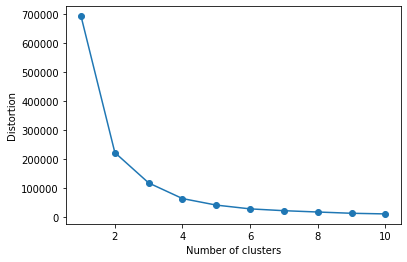

In [13]:
x_clusters=x_dummy[use_li]
distortions = []
for i  in range(1,11):            
    km = KMeans(n_clusters=i,
                init='k-means++',     
                random_state=2**2-1)
    km.fit(x_clusters)                  
    distortions.append(km.inertia_)  

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [14]:
def make_data(new_data,columns):
    data_num=len(new_data)
    x=pd.concat([new_data[i] for i in range(data_num)],axis=1)
    x.columns=columns
    return x

In [46]:
def ML(x,y,params,fase,use_li):
    #time
    start=time.time()
    count=0

    #paramaters
    if fase==0:
        thre_ratio=0.9
    elif fase == 1:
        thre_ratio=1.0
    rec_bias=1.0

    #others
    columns=x.columns
    importances=np.zeros(len(columns)+len(use_li)*2+1)
    pre=pd.Series(np.zeros(len(x)),index=x.index)
    pre_test=pd.Series(np.zeros(len(x)),index=x.index)
    prob=np.zeros(len(x))

    #set CV
    n_split=7
    cv=StratifiedKFold(n_splits=n_split,shuffle=True,random_state=2**2-1) 
    split_point=[int((n_split/5)*(i+1)) for i in range(5)]
    
    #data split
    for train_idx,val_idx in cv.split(x,y):
        #1 cross validation
        x_train=x.iloc[train_idx]
        y_train=y.iloc[train_idx]
        x_val=x.iloc[val_idx]
        y_val=y.iloc[val_idx]
        
        #特徴生成
        make_features_dis=[col+'_dis' for col in use_li]
        make_features_ratio=[col+'_ratio' for col in use_li]
        
        #クラスタリング        
        #クラスタリング        
        km=KMeans(n_clusters=4,init='k-means++',random_state=params['random_state'])
        km.fit(x_train[use_li])

        x_train['cluster']=km.predict(x_train[use_li])
        x_val['cluster']=km.predict(x_val[use_li])
        
        flag=False
        for i in range(4):  
            train_idx_cluster=x_train[x_train['cluster']==i].index
            val_idx_cluster=x_val[x_val['cluster']==i].index
            cluster_means=x_train[use_li].mean()
            
            train_cluster_dis=x_train.loc[train_idx_cluster][use_li]-cluster_means
            train_cluster_dis.columns=make_features_dis
            train_cluster_ratio=x_train.loc[train_idx_cluster][use_li]/cluster_means
            train_cluster_ratio.columns=make_features_ratio
            
            val_cluster_dis=x_val.loc[val_idx_cluster][use_li]-cluster_means
            val_cluster_dis.columns=make_features_dis
            val_cluster_ratio=x_val.loc[val_idx_cluster][use_li]/cluster_means
            val_cluster_ratio.columns=make_features_ratio
            
            train_cluster=pd.concat([train_cluster_dis,train_cluster_ratio],axis=1)
            val_cluster=pd.concat([val_cluster_dis,val_cluster_ratio],axis=1)
                     
            train_cluster['Rupture']=y_train.loc[train_idx_cluster]
            train_cluster_pos=train_cluster[train_cluster['Rupture']==1]
            train_cluster_neg=train_cluster[train_cluster['Rupture']==0]
            
            neg_num=int(len(y_train[y_train['Rupture']==1])*len(train_cluster)/len(y_train))+1
            if len(train_cluster_neg)<neg_num:
                neg_num=len(train_cluster_neg)
            train_cluster_neg=train_cluster_neg.sample(n=neg_num,random_state=params['random_state'])
            train_cluster=pd.concat([train_cluster_pos,train_cluster_neg])
            
            if i==0:
                train_clusters=train_cluster       
            else:
                train_clusters=pd.concat([train_clusters,train_cluster])
            
            if len(val_idx_cluster)!=0:
                val_cluster['Rupture']=y_val.loc[val_idx_cluster]
            if flag:
                val_clusters=pd.concat([val_clusters,val_cluster])
            else:
                if len(val_idx_cluster)!=0:
                    val_clusters=val_cluster
                    flag=True
                    
        y_train.Rupture=train_clusters.Rupture
        y_val.Rupture=val_clusters.Rupture
        train_clusters=train_clusters.drop('Rupture',axis=1)
        val_clusters=val_clusters.drop('Rupture',axis=1)
        
        train_idx=train_clusters.index
        val_idx=val_clusters.index
        
        x_train=x_train.loc[train_idx]
        y_train=y_train.loc[train_idx] 
        x_val=x_val.loc[val_idx]
        y_val=y_val.loc[val_idx]
        
        x_train=x_train.join(train_clusters)
        x_val=x_val.join(val_clusters)     
        columns=x_train.columns
        
        #make model
        model=lgb.LGBMModel(**params)
        model.fit(x_train,y_train)
        
        #repredict training data
        predict_train=model.predict(x_train)   
        
        #predict test data
        pre.loc[val_idx]=model.predict(x_val)

        #importances  
        importances+=model.feature_importances_
        
        #train AUC
        print('AUC:',mtr.roc_auc_score(y_train,predict_train))
        
        #report score
        best_score=0
        rec_li=[]
        spe_li=[]

        #get best threshold
        for threshold in predict_train:
            pre_train=np.where(predict_train>=threshold,1,0)
            rec=mtr.recall_score(y_train,pre_train)
            spe=mtr.recall_score(y_train,pre_train,pos_label=0)
            rec_li.append(rec)
            spe_li.append(spe)
            score=(2*rec*rec_bias*spe)/(rec*rec_bias+spe)
            if score>best_score:
                best_thre=threshold*thre_ratio
                best_score=score
                best_rec=rec
                best_spe=spe
                
        print('best_thre:'+str(best_thre))

        #make graph(score)
        if fase==0:
            x_f='Volume'
        elif fase==1:
            x_f='xgb_1'
        predict_train=pd.DataFrame(predict_train,index=train_idx,columns=['predict'])
        predict_train['ID']=x_train.index
        predict_train=predict_train.set_index('ID')
        for idx in y_train[y_train['Rupture']==0].index:
            plt.scatter(x_train.loc[idx][x_f],predict_train.loc[idx]['predict'],color='b')
        for idx in y_train[y_train['Rupture']==1].index:
            plt.scatter(x_train.loc[idx][x_f],predict_train.loc[idx]['predict'],color='r') 
        plt.xlabel(x_f)
        plt.ylabel('score')
        plt.show()
        
        #make graph(rec,spe)
        rec_spe=pd.DataFrame(np.array([rec_li,spe_li]).T,columns=['recall','specificity']).sort_values(['recall', 'specificity'])
        plt.figure(figsize=(5, 5))
        plt.xlim(0,1.01)
        plt.ylim(0,1.01)
        plt.scatter(rec_spe["recall"], rec_spe["specificity"],marker='o',c='b')
        plt.scatter(best_rec,best_spe,marker='o',c='r')
        plt.show()
    
        #make test label
        pre_test[val_idx]=np.where(model.predict(x_val)>=best_thre,1,0)

        #time score
        count+=1
        if count in split_point:
            print(str(int(count/n_split*100+0.5))+'%完了')

    #make pre(logistic)
    pre=pd.DataFrame(pre,columns=['predict'],index=x.index)
    pre_test=pd.DataFrame(pre_test,columns=['predict'],index=x.index)
    #final time score
    end=time.time()
    print('実行時間:'+str(int(end-start))+'s')
        
    #make importances
    importances=importances/sum(abs(importances))
    #return
    return pre,pre_test,importances

AUC: 1.0
best_thre:0.8998973461786894


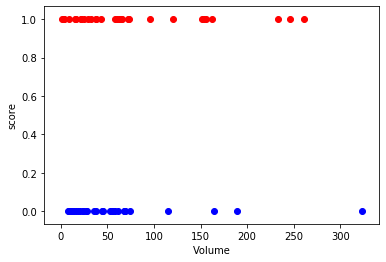

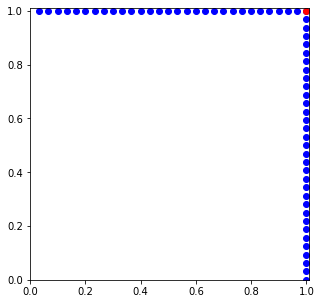

14%完了
AUC: 1.0
best_thre:0.8999233423257169


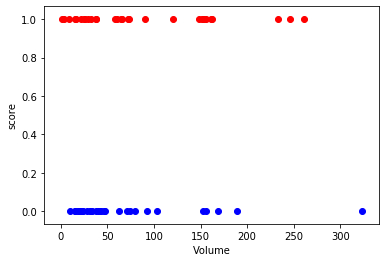

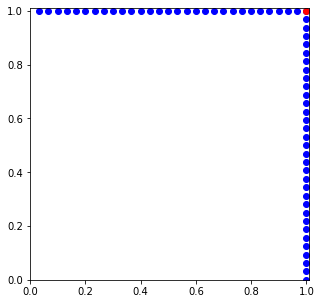

29%完了
AUC: 1.0
best_thre:0.8999194694339161


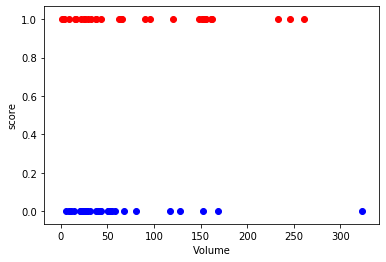

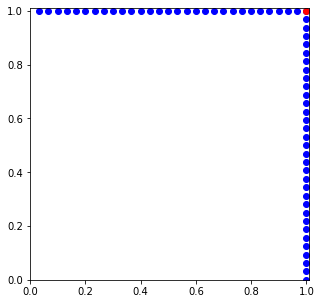

AUC: 1.0
best_thre:0.8999070461114655


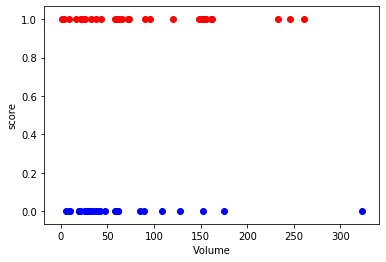

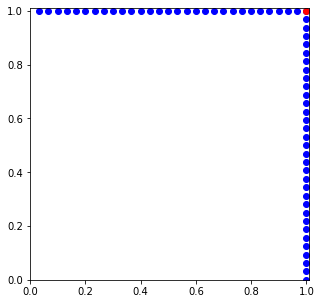

57%完了
AUC: 1.0
best_thre:0.8999060681264043


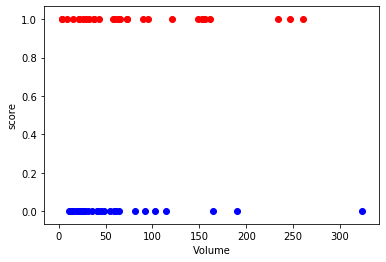

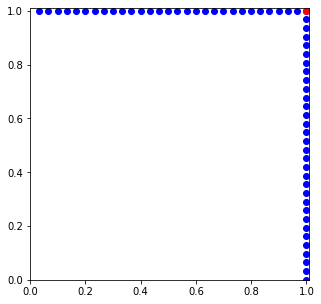

71%完了
AUC: 1.0
best_thre:0.8999173811226427


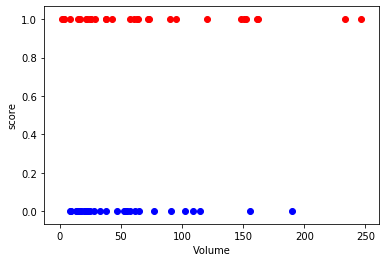

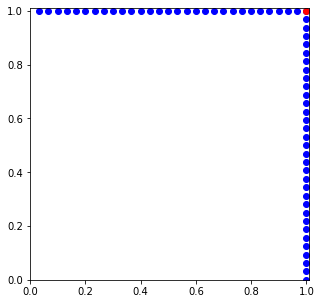

AUC: 1.0
best_thre:0.8999351442511749


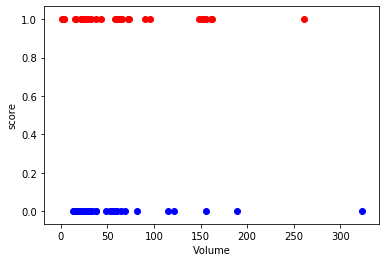

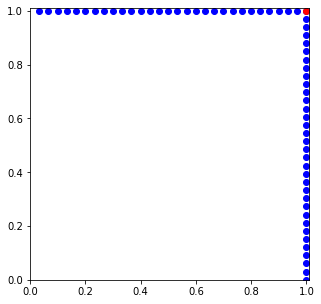

100%完了
実行時間:10s
0.42857142857142855 0.6996699669966997


In [55]:
pre_li=[]
pre_test_li=[]
rec_list=[]
spe_list=[]
params = {
    'max_depth':-1,
    'num_iterations':1000,
    'learning_rate': 0.1,
    'objective': 'binary',
    'silent':False
}
random_num=1
for i in range(random_num):
    params['random_state']=2**(i+1)-1
    pre,pre_test,importances=ML(x_dummy,y,params,0,use_li)
    pre_li.append(pd.DataFrame(pre))
    pre_test_li.append(pd.DataFrame(pre_test))
    rec_list.append(mtr.recall_score(y,pre_test))
    spe_list.append(mtr.recall_score(y,pre_test,pos_label=0))
for rec,spe in zip(rec_list,spe_list):
    print(rec,spe)

In [49]:
name_li=['xgb_'+str(i) for i in range(random_num)]
x_new=make_data(pre_li,name_li)
x_new2=make_data(pre_test_li,name_li)

In [ ]:
params['random_state']=2**2-1
pre,pre_test,importances=ML(x_new,y,params,1)
print(mtr.recall_score(y,pre_test))
print(mtr.recall_score(y,pre_test,pos_label=0))

In [ ]:
params['random_state']=2**2-1
pre,pre_test,importances=ML(x_new2,y,params,1)
print(mtr.recall_score(y,pre_test))
print(mtr.recall_score(y,pre_test,pos_label=0))

In [ ]:
cluster_col_cli=['AgeatRuporLasCon']
cluster_col_mor=[]
cluster_col_hem=['TMINSAWSS','TMINSMINWSS','TMAXSMINWSS','']